In [5]:
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt

import mne
from mne.baseline import rescale
from mne.datasets import somato
from mne.stats import bootstrap_confidence_interval

from corrts import *

In [6]:
data_path = somato.data_path()
subject = "01"
task = "somato"
raw_fname = data_path / f"sub-{subject}" / "meg" / f"sub-{subject}_task-{task}_meg.fif"

Using default location ~/mne_data for somato...


100%|████████████████████████████████████████| 611M/611M [00:00<00:00, 338GB/s]
Untarring contents of '/home/jmedrano/mne_data/MNE-somato-data.tar.gz' to '/home/jmedrano/mne_data'


Download complete in 02m11s (582.2 MB)


In [8]:
# set epoching parameters
event_id, tmin, tmax = 1, -2.0, 4.0
baseline = None

# get the header to extract events
raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel="STI 014")

# load the data to save memory
raw = mne.io.read_raw_fif(raw_fname)
raw.pick_types(meg="grad", eog=True)  # we just look at gradiometers
raw.load_data()

# bandpass filter
raw.filter(
    1,
    64,
    n_jobs=None,  # use more jobs to speed up.
    l_trans_bandwidth=1,  # make sure filter params are the same
    h_trans_bandwidth=1,
)  # in each band and skip "auto" option.

# epoch
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    baseline=baseline,
    reject=dict(grad=4000e-13, eog=350e-6),
    preload=True,
)
# remove evoked response
epochs.subtract_evoked()

Opening raw data file /home/jmedrano/mne_data/MNE-somato-data/sub-01/meg/sub-01_task-somato_meg.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
111 events found
Event IDs: [1]
Opening raw data file /home/jmedrano/mne_data/MNE-somato-data/sub-01/meg/sub-01_task-somato_meg.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Reading 0 ... 269399  =      0.000 ...   897.077 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 64.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
111 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 111 events and 1803 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']


[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    1.4s finished


    Rejecting  epoch based on EOG : ['EOG 061']
8 bad epochs dropped
Subtracting Evoked from Epochs
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    The following channels are not included in the subtraction: EOG 061
[done]


Number of events,103
Events,1: 103
Time range,-2.001 – 3.999 s
Baseline,off


In [23]:
data = epochs.get_data()

freq = np.linspace(1,60,32) 
rg   = 100
Nc   = np.maximum(1, np.round(np.sqrt(2 * (np.pi * freq)**2 / rg)))
print(Nc)

tfr  = mne.time_frequency.tfr_array_morlet(data, sfreq, freq, n_cycles=Nc, decim=2, output='power', n_jobs=11)
tfr  = np.sqrt(tfr)
tfr  = tfr[:, :, :, :2*(tfr.shape[-1] // 2)]

[ 1.  1.  2.  3.  4.  5.  6.  6.  7.  8.  9. 10. 11. 11. 12. 13. 14. 15.
 16. 17. 17. 18. 19. 20. 21. 22. 22. 23. 24. 25. 26. 27.]


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=11)]: Done  61 tasks      | elapsed:    3.5s
[Parallel(n_jobs=11)]: Done 151 tasks      | elapsed:    8.4s
[Parallel(n_jobs=11)]: Done 205 out of 205 | elapsed:   11.2s finished


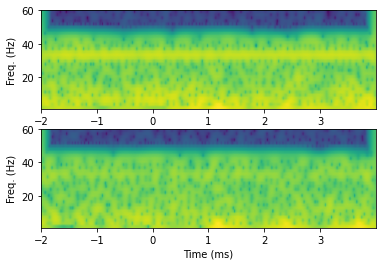

In [24]:
def plot_tfr(tfr, tvec, freq):
    extent = (tvec[0], tvec[-1], freq[0], freq[-1])
    
    plt.subplot(2,1,1)
    plt.imshow(tfr[0], aspect="auto", origin="lower", extent=extent)
    plt.xlabel('Time (ms)')
    plt.ylabel('Freq. (Hz)')
    
    plt.subplot(2,1,2)
    plt.imshow(tfr[1], aspect="auto", origin="lower", extent=extent)
    plt.xlabel('Time (ms)')
    plt.ylabel('Freq. (Hz)')
    
    plt.show()
    
plot_tfr(np.log(tfr[0]), epochs.times, freq)

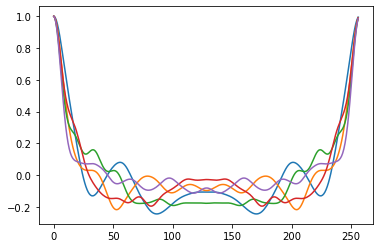

In [25]:
fbands = dict(
    delta = (freq[0], 4), 
    theta = (4, 8), 
    alpha = (8, 13),
    beta  = (13, 30), 
    gamma = (30, freq[-1])
)

idxs = {k: np.where(np.logical_and(freq >= fmin, freq < fmax))[0]
       for k, (fmin, fmax) in fbands.items()}

pband = {k: tfr[:,:,idx].sum(2) for k, idx in idxs.items()} 
acfs  = {k: acf_welch(p) for k, p in pband.items()} 

for k, acf in acfs.items(): 
    plt.plot(acf[0,0])

In [ ]:
pearson_stats  = {k: stats_summary(pearson_r,  p[:, :, None], p[:, None, :], n_surrogates=1000) for k, p in pband.items()}
# spearman_stats = {k: stats_summary(spearman_r, p[:, 0], p[:, 1], n_surrogates=1000) for k, p in pband.items()}

/home/jmedrano/prog/python/corrts/corrts/src.py:114: RuntimeWarning: invalid value encountered in sqrt
  return 2 * scipy.stats.norm.cdf(-np.abs(z), 0, 1./np.sqrt(n-3))


ValueError: Number of channels in the Info object (204) and the data array (103) do not match. Pick Info with e.g. mne.pick_info and mne.io.pick.channel_indices_by_type.

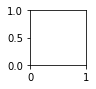

In [29]:
mne.viz.plot_topomap(pearson_stats['alpha']['r'], epochs.info)

In [42]:
epochs.get_data()

array([[[ 1.30690296e-12,  5.44133305e-12,  5.96230307e-12, ...,
         -9.72651970e-13,  1.50706021e-12,  5.65749089e-12],
        [ 8.12068827e-12,  7.12246790e-12,  4.63306021e-12, ...,
         -1.05581059e-12, -2.39950756e-12, -3.59296423e-12],
        [-2.70614115e-11, -1.67227872e-11, -9.07794443e-12, ...,
         -6.12329409e-14,  8.10466725e-12,  1.64724460e-11],
        ...,
        [-1.03825619e-11, -1.38427031e-11, -1.28355078e-11, ...,
         -1.14748771e-11, -1.34115986e-11, -1.48108902e-11],
        [-2.53951881e-13, -4.77309550e-12, -5.36853356e-12, ...,
          2.39965887e-12, -2.55513626e-12, -5.46265386e-12],
        [ 8.52853502e-04,  8.46804978e-04,  8.58902124e-04, ...,
          8.30675302e-04,  8.30675302e-04,  8.44788738e-04]],

       [[-6.51243209e-12, -1.02325380e-12,  1.20274081e-12, ...,
         -2.68116523e-12, -1.80609591e-12,  9.16705571e-13],
        [ 2.98355087e-12,  2.73344790e-13, -1.54467024e-12, ...,
          8.01405871e-13,  2.54050784e